# Essay Writer AI Agent


<img src="essay_writer.png" alt="essay writer" title="Essay Writer" width="400">



In [108]:
from dotenv import load_dotenv

_ = load_dotenv()

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [118]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [120]:
from langchain_core.pydantic_v1 import BaseModel
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
class Queries(BaseModel):
    queries: List[str]
    

In [121]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [123]:
builder = StateGraph(AgentState)
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)
builder.set_entry_point("planner")
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")
graph = builder.compile(checkpointer=memory)

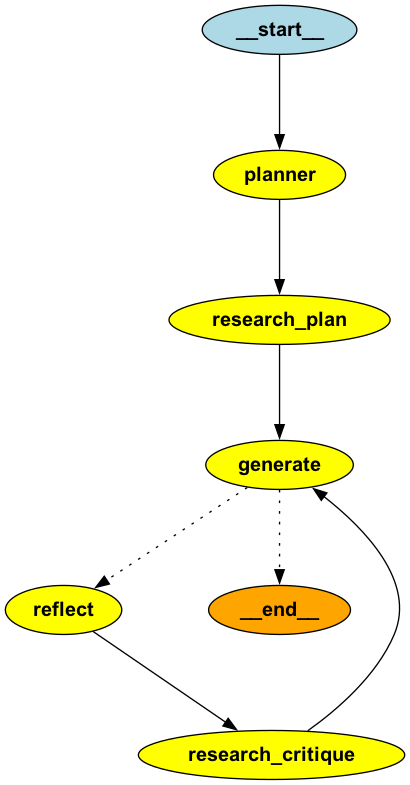

In [124]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [128]:
with SqliteSaver.from_conn_string(":memory:") as memory_saver:
    graph = builder.compile(checkpointer=memory_saver)

    thread = {"configurable": {"thread_id": "1"}}
    for s in graph.stream({
        'task': "what is the difference between langchain and langsmith",
        "max_revisions": 2,
        "revision_number": 1,
        'content': []
    }, thread):
        print(s)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of Langchain and Langsmith\n    B. Thesis statement: Exploring the differences between Langchain and Langsmith\n\nII. Langchain\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. Langsmith\n    A. Definition and explanation\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between Langchain and Langsmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Flexibility\n    E. Performance\n\nV. Conclusion\n    A. Recap of the main differences between Langchain and Langsmith\n    B. Implications for the future of blockchain technology\n    C. Final thoughts and recommendations\n\nNotes:\n- Ensure a clear and concise explanation of both Langchain and Langsmith.\n- Provide specific examples of how each technology is used in real-w

/opt/anaconda3/envs/ml_hw4/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/opt/anaconda3/envs/ml_hw4/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'research_plan': {'content': ['LangChain vs LangSmith: Understanding the Differences, Pros, and Cons | by Ajay Verma | GoPenAI LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. In this blog, we’ll delve into the differences between LangChain and LangSmith, their pros and cons, and when to use each one. Comprehensive Platform: LangSmith offers a unified platform for managing all aspects of LLM development, making it ideal for large-scale, production-ready applications. LangChain and LangSmith are two complementary tools that cater to different stages and requirements of LLM development. LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications that require advanced debugging, testing, and monitoring capabilities.', 'If you’re responsible for ensuring your AI models work 

/opt/anaconda3/envs/ml_hw4/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1844: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/opt/anaconda3/envs/ml_hw4/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1857: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'research_critique': {'content': ['LangChain vs LangSmith: Understanding the Differences, Pros, and Cons | by Ajay Verma | GoPenAI LangChain and LangSmith are two powerful tools developed by LangChain, a company focused on making it easier to build and deploy Large Language Model (LLM) applications. In this blog, we’ll delve into the differences between LangChain and LangSmith, their pros and cons, and when to use each one. Comprehensive Platform: LangSmith offers a unified platform for managing all aspects of LLM development, making it ideal for large-scale, production-ready applications. LangChain and LangSmith are two complementary tools that cater to different stages and requirements of LLM development. LangChain is ideal for early-stage prototyping and small-scale applications, while LangSmith is better suited for large-scale, production-ready applications that require advanced debugging, testing, and monitoring capabilities.', 'If you’re responsible for ensuring your AI models w

# Resources
Link: https://python.langchain.com/docs/introduction/

Cookbook/Github: https://github.com/langchain-ai/langchain/tree/master/cookbook